In [1]:
# TODO 
# SineReLU
# keras fit_one_cycle
# transfer learning
# box bounding before keypoints prediction

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Dense, Activation, SeparableConv2D, MaxPooling2D, Flatten, Dropout, 
                          BatchNormalization)
from keras.optimizers import Adam

import imgaug
from imgaug import augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample, plot_loss, load_model, save_model
from model import MyModel

Using TensorFlow backend.


In [4]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 80

In [5]:
X, y = load(images_path, labels_path)

X_train, X_test_, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(4192, 80, 80, 3) (898, 80, 80, 3) (899, 80, 80, 3)


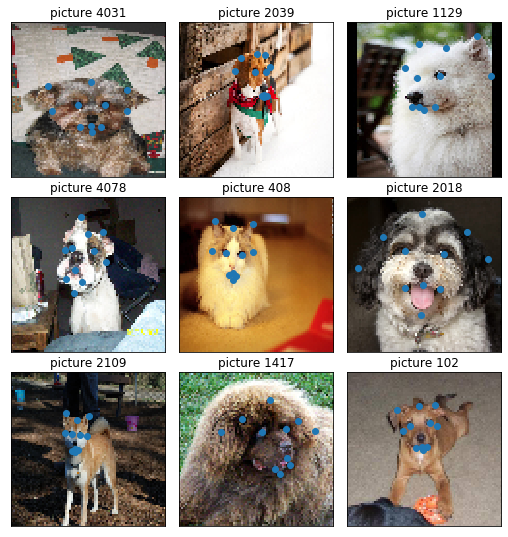

In [6]:
plot_labelled_sample(X_train, y_train, 80, False)

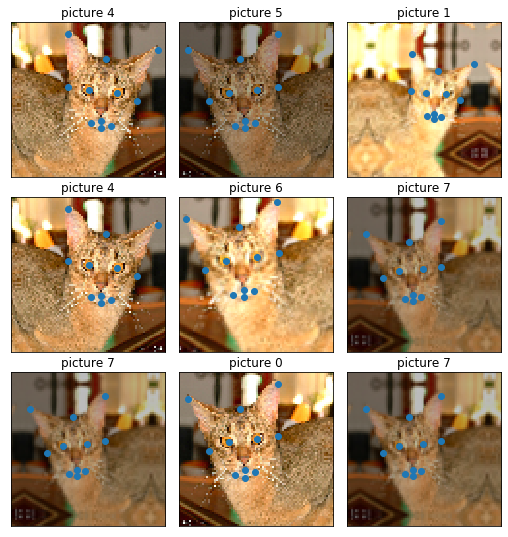

In [28]:
for a, b in generator(X[2:3], y.iloc[2:3], 9, target_size):
    plot_labelled_sample(a, b, target_size)   
    break

In [131]:
model = MyModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_45 (Separab (None, 78, 78, 32)        155       
_________________________________________________________________
separable_conv2d_46 (Separab (None, 76, 76, 64)        2400      
_________________________________________________________________
batch_normalization_23 (Batc (None, 76, 76, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
separable_conv2d_47 (Separab (None, 36, 36, 64)        4736      
_________________________________________________________________
separable_conv2d_48 (Separab (None, 34, 34, 128)       8896      
_________________________________________________________________
batch_normalization_24 (Batc (None, 34, 34, 128)       512       
__________

In [132]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

epochs = 50
batch_size = 64

hist = model.fit_generator(
                    generator(X_train, y_train, batch_size=batch_size, target_size=target_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=(X_val/255, (y_val - (target_size/2)) / (target_size/2))
                   )

Epoch 1/50
66/65 [==============================] - 105s 2s/step - loss: 0.0618 - val_loss: 0.0856
Epoch 2/50
66/65 [==============================] - 102s 2s/step - loss: 0.0534 - val_loss: 0.0808
Epoch 3/50
66/65 [==============================] - 101s 2s/step - loss: 0.0504 - val_loss: 0.0801
Epoch 4/50
66/65 [==============================] - 102s 2s/step - loss: 0.0485 - val_loss: 0.0817
Epoch 5/50
66/65 [==============================] - 100s 2s/step - loss: 0.0482 - val_loss: 0.0812
Epoch 6/50
66/65 [==============================] - 101s 2s/step - loss: 0.0481 - val_loss: 0.0809
Epoch 7/50
66/65 [==============================] - 100s 2s/step - loss: 0.0464 - val_loss: 0.0754
Epoch 8/50
66/65 [==============================] - 100s 2s/step - loss: 0.0461 - val_loss: 0.0812
Epoch 9/50
66/65 [==============================] - 99s 1s/step - loss: 0.0450 - val_loss: 0.0816
Epoch 10/50
66/65 [==============================] - 101s 2s/step - loss: 0.0439 - val_loss: 0.0769
Epoch 11/5

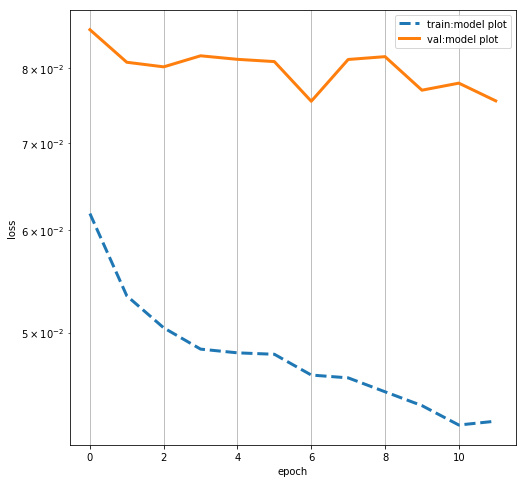

In [133]:
plot_loss(hist, "model plot")

In [134]:
model.load_weights('../models/my_model.h5')

In [135]:
model = load_model("my_model")
save_model(model, "my_model")

In [136]:
y_pred = pd.DataFrame(model.predict(X_test/255))

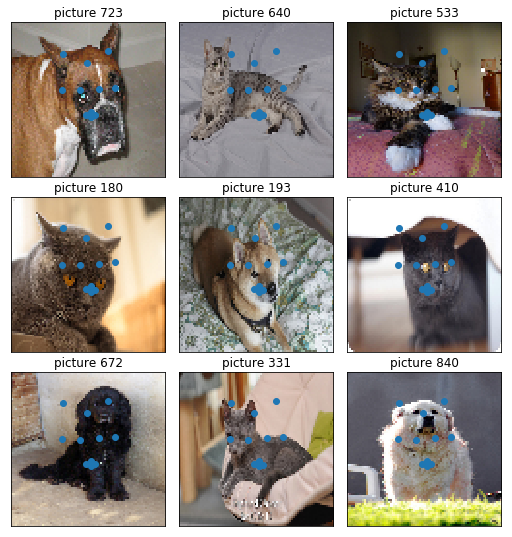

In [137]:
plot_labelled_sample(X_test/255, (y_pred - (target_size/2)) / (target_size/2), 80)